In [6]:
from Classes.Analysis import Analysis
import numpy as np
from matplotlib import pyplot as plt
from Classes.Visualizer import Visualizer

class System(Analysis):
    def __init__(self, graph_location):
        super().__init__(graph_location)

    def odesystem(self, t, Y, *params):
        #TODO: look at biology side, try to replicate graphs
        #TODO: explore the model(s)
        # start simple, bacteria-resource, see how the bacteria and reosurces grow/shrink, bacteria should hit carrying capacity, nutrient should reach 0, not negative, etc
        graph_object, phage_nodes, bacteria_nodes, nutrient_nodes, M, e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix = params
        graph = graph_object.graph
        def g(N, v, K):
            return (N * v) / (N + K)

        Y = self.check_cutoff(Y)
        
        N, U, I, P = self.unflatten_initial_matrix(Y, [len(nutrient_nodes), len(bacteria_nodes), (len(bacteria_nodes), M), len(phage_nodes)])
        new_N = np.zeros_like(N)
        new_U = np.zeros_like(U)
        new_I = np.zeros_like(I)
        new_P = np.zeros_like(P)
        #update N vector
        for nutrient in nutrient_nodes:
            n_index = nutrient_nodes.index(nutrient)
            e_value = e_vector[n_index] 
            sum_g = 0
            sum_u = 0
            sum_i = 0
            for bacteria in bacteria_nodes:
                b_index = bacteria_nodes.index(bacteria)
                if graph.has_edge(bacteria, nutrient):
                    v = v_matrix[b_index, n_index]
                    K = K_matrix[b_index, n_index]
                    sum_g += g(N[n_index], v, K)
                    sum_u += U[b_index]
                    sum_i += np.sum(I[b_index])
            new_N[n_index] = -(e_value * sum_g) * (sum_u + sum_i)
        
        # update U vector, i, and j are flipped relative to what is seen in update N vector for v, K, and r matrices because of how the row and columns are defined in the graph
        # dont sum U in left and right, because we are looking at an individual bacteria
        for uninfected in bacteria_nodes:
            u_index = bacteria_nodes.index(uninfected)
            g_sum = 0
            right = 0
            for nutrient in nutrient_nodes:
                n_index = nutrient_nodes.index(nutrient)
                if graph.has_edge(uninfected, nutrient):
                    g_sum += g(N[n_index], v_matrix[u_index, n_index], K_matrix[u_index, n_index])
            for phage in phage_nodes:
                p_index = phage_nodes.index(phage)
                if graph.has_edge(phage, uninfected):
                    right += r_matrix[p_index, u_index] * P[p_index]
            new_U[u_index] = g_sum * U[u_index] - right * U[u_index]

        for infected in bacteria_nodes:
            i_index = bacteria_nodes.index(infected)
            for infected_stage in range(0, M):
                if infected_stage == 0:
                    left_sum = 0
                    right_sum = 0
                    for phage in phage_nodes:
                        p_index = phage_nodes.index(phage)
                        if graph.has_edge(phage, infected):
                            left_sum += r_matrix[p_index, i_index] * P[p_index]
                            right_sum += M / tau_vector[i_index] * I[i_index, 0]
                    new_I[i_index, 0] = left_sum * U[i_index] - right_sum
                else:
                    m_tau = M / tau_vector[i_index]
                    right = I[i_index, infected_stage - 1] - I[i_index, infected_stage]
                    new_I[i_index, infected_stage] = m_tau * right
        
        for phage in phage_nodes:
            p_index = phage_nodes.index(phage)
            left_sum = 0
            right_sum = 0
            for infected in bacteria_nodes:
                i_index = bacteria_nodes.index(infected)
                if graph.has_edge(phage, infected):
                    left_sum += B_matrix[p_index, i_index] * M / tau_vector[i_index] * I[i_index, -1]
                    right_sum += r_matrix[p_index, i_index] * (U[i_index] + np.sum(I[i_index])) * P[p_index]
            new_P[p_index] = left_sum - right_sum

        flattened_y1 = self.flatten_lists_and_matrices(new_N, new_U, new_I, new_P)
        return flattened_y1

In [ ]:
graph = System('simple_test_2.gexf')
phage_nodes = graph.get_nodes_of_type('P')
bacteria_nodes = graph.get_nodes_of_type('B')
resource_nodes = graph.get_nodes_of_type('R')
environemnt_nodes = graph.get_nodes_of_type('E')

R0 = graph.initialize_new_parameter_from_node(resource_nodes, "Initial_Concentration")
U0 = graph.initialize_new_parameter_from_node(bacteria_nodes, "Initial_Population")
I0 = graph.initialize_new_matrix(len(U0), graph.M)
P0 = graph.initialize_new_parameter_from_node(phage_nodes, "Initial_Population")

e_vector = graph.initialize_new_parameter_from_node(resource_nodes, 'e')
tau_vector = graph.initialize_new_parameter_from_node(bacteria_nodes, 'tau')
v_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'v')
K_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'K')
r_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'r')
B_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'Burst_Size')
visualizer = Visualizer(graph)

In [8]:
new_graphing_data = [R0, U0, I0, P0]
flattened = graph.flatten_lists_and_matrices(*new_graphing_data)
new_non_graphing_data_vectors = [e_vector, tau_vector]
new_non_graphing_data_matrices = [v_matrix, K_matrix, r_matrix, B_matrix]

solved_system = graph.solve_system(graph.odesystem, flattened, graph, *[phage_nodes, bacteria_nodes, resource_nodes, int(graph.M)], *new_non_graphing_data_vectors, *new_non_graphing_data_matrices)
solved_y = solved_system.y
overall_y = graph.unflatten_initial_matrix(solved_system.y, [len(resource_nodes), len(bacteria_nodes), int(graph.M), len(phage_nodes)])
overall_y[2] = visualizer.sum_up_columns(overall_y[2], int(graph.M))

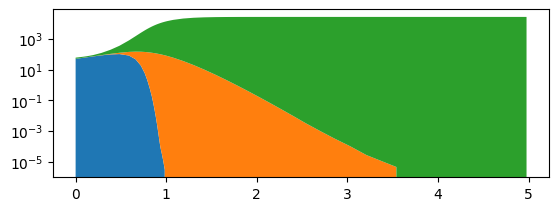

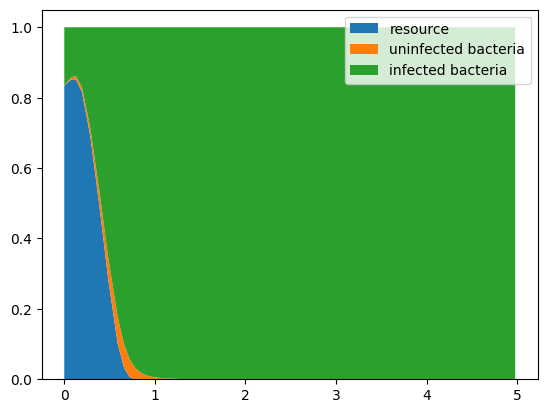

In [18]:
new_graphing_data = [R0, U0, I0, P0]
flattened = graph.flatten_lists_and_matrices(*new_graphing_data)
new_non_graphing_data_vectors = [e_vector, tau_vector]
new_non_graphing_data_matrices = [v_matrix, K_matrix, r_matrix, B_matrix]

solved_system = graph.solve_system(graph.odesystem, flattened, graph, *[phage_nodes, bacteria_nodes, resource_nodes, int(graph.M)], *new_non_graphing_data_vectors, *new_non_graphing_data_matrices)
solved_y = solved_system.y
overall_y = graph.unflatten_initial_matrix(solved_system.y, [len(resource_nodes), len(bacteria_nodes), int(graph.M), len(phage_nodes)])
overall_y[2] = visualizer.sum_up_columns(overall_y[2], int(graph.M))
new_overall_y = [overall_y[i][0] for i in range(len(overall_y))]
number_time_steps_to_show = 50
solved_t = solved_system.t
solved_t_new = solved_t[:number_time_steps_to_show]
for i in range(len(new_overall_y)):
    new_overall_y[i] = new_overall_y[i][:number_time_steps_to_show]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

new_overall_y = new_overall_y[1:4]
line = ax.stackplot(solved_t_new, new_overall_y, labels=["resource", "uninfected bacteria", "infected bacteria", "phage"])

ax.set_yscale('log')
# plt.stackplot(solved_t_new, new_overall_y, labels=["resource", "uninfected bacteria", "infected bacteria", "phage"])
# plt.set_yscale('log')
# plt.legend()
plt.show()

new_overall_y = np.array(new_overall_y)
column_sums = new_overall_y.sum(axis=0)
new_overall_y = new_overall_y / column_sums
plt.stackplot(solved_t_new, new_overall_y, labels=["resource", "uninfected bacteria", "infected bacteria", "phage"])
plt.legend(loc='upper right')
# plots from https://enviromicro-journals.onlinelibrary.wiley.com/doi/full/10.1111/1462-2920.13743
# TODO: remove resources form grpahs below

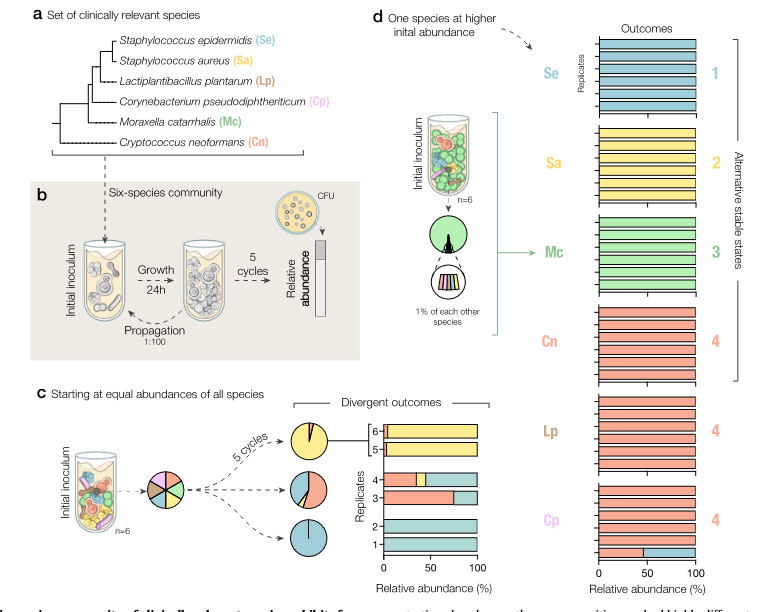

In [8]:
import dash
from dash import dcc, html
import plotly.graph_objects as go

app = dash.Dash(__name__)

data = {
    "name1": [[1, 2, 3, 1, 3, 1], [3, 4, 4], [1, 2, 1], [1, 2, 1], [1, 2, 1]],
    "name2": [[2, 3, 5,4], [1, 2, 1], [1, 2, 1], [1, 2, 1], [1, 2, 1]],
    "name3": [[1, 2, 3, 1, 3, 1], [3, 4, 4], [3, 4, 4], [3, 4, 4], [3, 4, 4]]
}

group_names = list(data.keys())
bar_labels = []
num_stacks_per_bar = len(data[group_names[0]][0])

# Construct x-tick positions: one per bar, grouped by name1/name2
x = []
bar_labels = ["resources", "b", "u", "i", "p"]  # group label repeated for each bar

# Build traces (one per stack layer)
traces = []
for stack_index in range(num_stacks_per_bar):
    y = []
    for group in group_names:
        for sublist in data[group]:
            y.append(sublist[stack_index])
    traces.append(
        go.Bar(
            x=x,
            y=y,
            name=f"Stack {stack_index + 1}"
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    barmode='stack',
    xaxis=dict(
        tickmode='array',
        tickvals=x,
        ticktext=bar_labels,
        title='Group'
    ),
    title='Grouped and Stacked Bar Plot'
)

app.layout = html.Div([
    dcc.Graph(figure=fig)
])

if __name__ == '__main__':
    app.run(debug=True)

IndexError: list index out of range

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

data = {
    "Initial Inoculation": {
        "group_names": ["Resources", "Phages"],
        "column names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 2": {
        "group_names": ["Resources", "Phages"],
        "column names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 3": {
        "group_names": ["Resources", "Phages"],
        "column names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
}

fig = go.Figure()

for group, group_data in data.items():
    group_names = group_data["group_names"]
    column_names = group_data["column names"]
    column_data = group_data["column_data"]

    for i, (col_name, col_values) in enumerate(zip(column_names, column_data)):
        for j, value in enumerate(col_values):
            fig.add_trace(go.Bar(
                x=[f"{group}_{group_names[i]}"],
                y=[value],
                name=f"{group_names[i]}_{col_name[j]}",
                offsetgroup=j,
                legendgroup=group_names[i],
                width=0.5
            ))

fig.update_layout(
    barmode="stack",
    title="Stacked Grouped Barplot",
    xaxis_title="Groups",
    yaxis_title="Values",
    legend_title="Legend"
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
x=['b', 'a', 'c', 'd']
fig = go.Figure(go.Bar(x=x, y=[2,5,1], name='Montreal'))
fig.add_trace(go.Bar(x=x, y=[1, 4, 9, 16], name='Ottawa'))
fig.add_trace(go.Bar(x=x, y=[6, 8, 4.5, 8], name='Toronto'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [5]:
import dash
from dash import dcc, html
import plotly.graph_objects as go

# Input data
data = {
    "Initial Inoculation": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 2": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 3": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
}

# Step 1: Flatten data for stacked bars
records = []

for group_label, group_data in data.items():
    group_names = group_data["group_names"]
    column_names = group_data["column_names"]
    column_data = group_data["column_data"]

    for group_name, names_list, values_list in zip(group_names, column_names, column_data):
        for name, value in zip(names_list, values_list):
            records.append({
                "x": f"{group_label} - {group_name}",  # composite x-axis label
                "stack_label": name,
                "value": value
            })

# Step 2: Create bar traces
from collections import defaultdict

grouped = defaultdict(list)
for record in records:
    grouped[record["stack_label"]].append(record)

traces = []
x_order = sorted(list({r['x'] for r in records}))  # Preserve consistent order

for stack_label, entries in grouped.items():
    # Match values to correct x positions
    y_vals = []
    for x in x_order:
        match = next((e['value'] for e in entries if e['x'] == x), 0)
        y_vals.append(match)

    traces.append(go.Bar(
        x=x_order,
        y=y_vals,
        name=stack_label
    ))

# Step 3: Create figure
fig = go.Figure(data=traces)
fig.update_layout(
    barmode='stack',
    title='Grouped and Stacked Bar Plot',
    xaxis_title='Condition - Type',
    yaxis_title='Value',
    xaxis_tickangle=30
)

# Step 4: Dash layout
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Grouped + Stacked Bar Plot"),
    dcc.Graph(figure=fig)
])

if __name__ == '__main__':
    app.run(debug=True)

In [25]:
import dash
from dash import dcc, html
import plotly.graph_objects as go

data = {
    "Initial Inoculation": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 2": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 3": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 4": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 5": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 6": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 7": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 8": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 9": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
    "Initial Inoculation 10": {
        "group_names": ["Resources", "Phages"],
        "column_names": [["r0", "r1", "r2", "r3"], ["p1", "p2", "p3"]],
        "column_data": [[1, 2, 4, 1], [3, 4, 4]]
    },
}

# Step 1: Flatten and assign numeric x positions
records = []
x_pos = 0
x_labels = []
group_gap = 0.01  # wider spacing between groups
intra_group_gap = 0.01  # small spacing between phages and resources

for group_label, group_data in data.items():
    group_names = group_data["group_names"]
    column_names = group_data["column_names"]
    column_data = group_data["column_data"]

    for i, (group_name, col_names, col_vals) in enumerate(zip(group_names, column_names, column_data)):
        xpos = x_pos + i * intra_group_gap
        label = f"{group_label}<br>{group_name}"
        x_labels.append((xpos, label))

        for name, val in zip(col_names, col_vals):
            records.append({
                "x": xpos,
                "x_label": label,
                "stack_label": name,
                "value": val
            })
    x_pos += len(group_names) * intra_group_gap + group_gap

# Step 2: Build plotly bar traces from individual stack segments
from collections import defaultdict

grouped = defaultdict(list)
for r in records:
    grouped[r["stack_label"]].append(r)

traces = []
x_tick_vals = []
x_tick_texts = []

for stack_label, entries in grouped.items():
    traces.append(go.Bar(
        x=[e["x"] for e in entries],
        y=[e["value"] for e in entries],
        name=stack_label
    ))

# Only unique x-labels
for xpos, label in dict(sorted(x_labels)).items():
    x_tick_vals.append(xpos)
    x_tick_texts.append(label)

# Step 3: Plot setup
fig = go.Figure(data=traces)
fig.update_layout(
    barmode="stack",
    title="Grouped + Stacked Bar Plot with Spacing",
    xaxis=dict(
        tickmode="array",
        tickvals=x_tick_vals,
        ticktext=x_tick_texts,
        tickangle=90
    ),
    yaxis_title="Value"
)

# Step 4: Dash Layout
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Grouped + Stacked Bar Plot (Spaced Layout)"),
    dcc.Graph(figure=fig)
])

if __name__ == "__main__":
    app.run(debug=True)